In [2]:
import re
import math

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request as urllib2

!pip install optuna --quiet


from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from zipfile import ZipFile
from io import BytesIO
import optuna

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

!pip install mlflow --quiet
get_ipython().system_raw("mlflow ui --port 5000 &")

!pip install pyngrok --quiet

from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()


# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

import mlflow

MLflow Tracking UI: https://8f23e022e84d.ngrok.io


# **Manage and Load Dataset**

In [3]:
#Getting zipped file and load csv cities temperature file 
zipCityTemp = urllib2.urlopen("https://raw.githubusercontent.com/renatopaulobs/notes-node/master/city_temperature.zip").read()
file = ZipFile(BytesIO(zipCityTemp))
citiesTemp = pd.read_csv(file.open("city_temperature.csv"))

#Setting category types in columns there are not numbers(float, int)
citiesTemp['Region'] = citiesTemp['Region'].astype('category')
citiesTemp['Country'] = citiesTemp['Country'].astype('category')
citiesTemp['State'] = citiesTemp['State'].astype('category')
citiesTemp['City'] = citiesTemp['City'].astype('category')

#removing rows duplicated
citiesTemp = citiesTemp.drop_duplicates()

#Remove all -99 avgTemperature occurrency
citiesTemp=citiesTemp.drop(citiesTemp[citiesTemp['AvgTemperature']==-99.0].index)

#Removing State Column due to a great number of NaN occurrencies 50%
citiesTemp = citiesTemp.drop('State',axis=1)

#Convert AvgTemperature to Celsius
citiesTemp['AvgTemperature'] = (citiesTemp['AvgTemperature'] -32)*(5/9)

mapping = {'Africa': 1, 'Asia': 2, 'Australia/South Pacific': 3, 'Europe': 4, 'Middle East': 5, 'North America': 6, 'South/Central America & Carribean': 7}
citiesTemp = citiesTemp.replace({'Region': mapping})

citiesTemp.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



,Region,Country,City,Month,Day,Year,AvgTemperature
1239,1,Burundi,Bujumbura,7,18,2003,27.388889
1431,1,Burundi,Bujumbura,1,26,2004,13.388889
1444,1,Burundi,Bujumbura,2,8,2004,26.777778
1445,1,Burundi,Bujumbura,2,9,2004,16.500000
1446,1,Burundi,Bujumbura,2,10,2004,20.555556


# **Separating Prediction / Test Data**

In [8]:
features_results = citiesTemp.drop(columns=['Region', 'Country', 'City'])
labels_results = citiesTemp['Region']

X_train, X_test, y_train, y_test = train_test_split(features_results, labels_results, test_size=0.25, shuffle=False)
X_train, X_valid, y_train, y_valid =  train_test_split(X_train, y_train, test_size=(1/3), shuffle=False)


# **ML Algorithms:**


In [5]:
from optuna.integration.mlflow import MLflowCallback
mlflc = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(),
    metric_name="Accuracy",
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ExperimentalWarning:

MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.



# **Decision Tree**


In [8]:
@mlflc.track_in_mlflow()
def decisionTree(trial):
    max_depth = trial.suggest_int("max_depth", 1, 20, 1)
    split     = trial.suggest_int('min_samples_split', 3, 20, 1)
    leaf      = trial.suggest_int('min_samples_leaf', 3, 20, 1)

    decisionTree_selection = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=leaf, min_samples_split=split)
    decisionTree_selection.fit(X_train, y_train)
    
    prediction_validation = decisionTree_selection.predict(X_valid)
    accuracy_validation = accuracy_score(y_valid, prediction_validation)

    return accuracy_validation

study_dt = optuna.create_study(direction="maximize", study_name="Decision Tree")
mlflow.end_run()
study_dt.optimize(decisionTree, n_trials=20, callbacks=[mlflc])
print(study_dt.best_trial.value)
print(study_dt.best_trial.params)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ExperimentalWarning:

track_in_mlflow is experimental (supported from v2.9.0). The interface can change in the future.

[I 2021-08-16 16:57:23,854] A new study created in memory with name: Decision Tree
[I 2021-08-16 16:57:28,968] Trial 0 finished with value: 0.05788545700702119 and parameters: {'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.05788545700702119.
[I 2021-08-16 16:57:33,131] Trial 1 finished with value: 0.03802118664685964 and parameters: {'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.05788545700702119.
[I 2021-08-16 16:57:35,473] Trial 2 finished with value: 0.02786865538353212 and parameters: {'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.05788545700702119.
[I 2021-08-16 16:57:39,148] Trial 3 finished with value: 0.031048656013235216 and parameters: {'max_depth'

0.06664977917457374
{'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 10}


# **MLP**

In [ ]:

@mlflc.track_in_mlflow()
def MLP(trial):
    layer_size = trial.suggest_int('hidden_layer_sizes', 10, 1000, 10)
    activation = trial.suggest_categorical('activation', ['logistic', 'relu', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    mlp_selection = MLPClassifier(layer_size, activation=activation, solver=solver)
    mlp_selection.fit(X_train, y_train)     

    prediction_validation = mlp_selection.predict(X_valid)
    accuracy_validation = accuracy_score(y_valid, prediction_validation)

    return accuracy_validation

study_mlp = optuna.create_study(direction="maximize", study_name="MLP")
mlflow.end_run()
study_mlp.optimize(MLP, n_trials=20, callbacks=[mlflc])
print(study_mlp.best_trial.value)
print(study_mlp.best_trial.params)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

track_in_mlflow is experimental (supported from v2.9.0). The interface can change in the future.

[I 2021-08-16 17:01:12,060] A new study created in memory with name: MLP


INFO: 'MLP' does not exist. Creating a new experiment


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning:

Training interrupted by user.



KeyboardInterrupt: ignored

# **KMN**

In [ ]:
@mlflc.track_in_mlflow()
def KNN(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 5 , 500)
    knn_selection = KNeighborsClassifier(n_neighbors)
    knn_selection.fit(X_train, y_train)     

    prediction_validation = knn_selection.predict(X_valid)
    accuracy_validation = accuracy_score(y_valid, prediction_validation)

    return accuracy_validation

study_knn = optuna.create_study(direction="maximize", study_name="KNN")
mlflow.end_run()
study_knn.optimize(KNN, n_trials=20, callbacks=[mlflc])
print(study_knn.best_trial.value)
print(study_knn.best_trial.params)

# **Naive Bayes**


In [ ]:
@mlflc.track_in_mlflow()
def naiveBayes(trial):
    nb_var_smoothing = trial.suggest_float('var_smoothing', 1e-9, 1e9, log=True)

    naiveBayes_selection = GaussianNB(var_smoothing=nb_var_smoothing)
    naiveBayes_selection.fit(X_train, y_train)     

    prediction_validation = naiveBayes_selection.predict(X_valid)
    accuracy_validation = accuracy_score(y_valid, prediction_validation)

    return accuracy_validation

study_nb = optuna.create_study(direction="maximize", study_name="Neive Bayes")
mlflow.end_run()
study_nb.optimize(naiveBayes, n_trials=20, callbacks=[mlflc])
print(study_nb.best_trial.value)
print(study_nb.best_trial.params)

# **Diagnosis**



*   Decision Tree algorithm has the best accuracy for the problem



,column,column_importance
0,AvgTemperature,0.579540
1,Month,0.172789
2,Year,0.124933
3,Day,0.122737


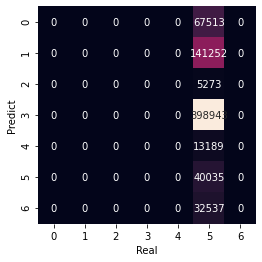

In [11]:
max_depth = 20
split     = 5
leaf      = 10

decisionTree_selection = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=leaf, min_samples_split=split)
decisionTree_selection.fit(X_train, y_train)

y_test_prediction   = decisionTree_selection.predict(X_test)
accuracy_validation = accuracy_score(y_test, y_test_prediction)

confusionMatrix = confusion_matrix(y_test, y_test_prediction)

sns.heatmap(confusionMatrix.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Real')
plt.ylabel('Predict');

In [12]:
column_importance = pd.DataFrame({'column': X_train.columns, 'column_importance': decisionTree_selection.feature_importances_})
column_importance = column_importance.sort_values('column_importance', ascending=False).reset_index(drop=True)
column_importance

,column,column_importance
0,AvgTemperature,0.579540
1,Month,0.172789
2,Year,0.124933
3,Day,0.122737
